**AZ Watch** is a popular video streaming platform specialized in educational content, where creators publish online video tutorials and lessons about any topic, from speaking a new language to cooking to learning to play a musical instrument.

Their next goal is to leverage AI-driven solutions to analyze and make predictions about their subscribers and improve their marketing strategy around attracting new subscribers and retaining current ones. This project uses machine learning to predict subscribers likely to churn and find customer segments. This may help AZ Watch find interesting usage patterns to build subscriber personas in future marketing plans!

![Woman working on multiple screens](marketinganalytics.jpg)


The `data/AZWatch_subscribers.csv` **dataset** contains information about subscribers and their status over the last year:

|Column name|Description|
|-----------|-----------|
|`subscriber_id`|The unique identifier of each subscriber user|
|`age_group`|The subscriber's age group|
|`engagement_time`|Average time (in minutes) spent by the subscriber per session|
|`engagement_frequency`|Average weekly number of times the subscriber logged in the platform (sessions) over a year period|
|`subscription_status`|Whether the user remained subscribed to the platform by the end of the year period (subscribed), or unsubscribed and terminated her/his services (churned)|



In [2]:
# Import the necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

# Specify the file path of your CSV file
file_path = "AZWatch_subscribers.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Separate predictor variables from class label
X = df.drop(['subscriber_id','subscription_status'], axis=1)
y = df.subscription_status

# Split intro training and test sets (20% test)
X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=.2, random_state=42)


Logistic regression accuracy score:  0.925

Decision tree accuracy score:  0.92

Random Forest accuracy score:  0.915

Confusion Matrix:
 [[101   8]
 [  7  84]]

Percentage of customers predicted to churn: 46.00%


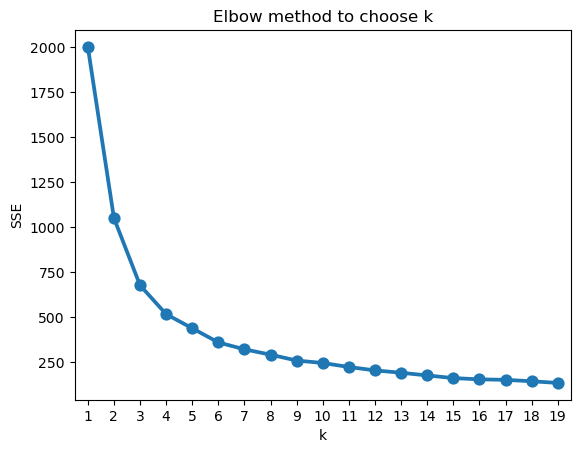

,engagement_time,engagement_frequency
,mean,mean
cluster_id,,
0,4.0,5.0
1,7.0,18.0
2,9.0,9.0


In [5]:
## Data processing: Apply One Hot Encoding on the categorical attribute: age_group
X_train_prepared = pd.get_dummies(X_train, columns=['age_group'])

# Data processing:Apply the same one hot encoding transformation on the test data
X_test_prepared = pd.get_dummies(X_test, columns=['age_group'])

# LOGISTIC REGRESSION CLASSIFIER
# Train a logistic regression classifier for subscriber churn prediction
model1 = LogisticRegression()
model1.fit(X_train_prepared, y_train)

# Calculate accuracy score of predictions on test set
score = model1.score(X_test_prepared, y_test)
print("\nLogistic regression accuracy score: ", score)

# DECISION TREE CLASSIFIER
# Train a decision tree classifier for subscriber churn prediction
model2 = DecisionTreeClassifier(max_depth=3, criterion="gini")
model2.fit(X_train_prepared, y_train)

# Calculate decision tree's accuracy score of predictions on test set
score = model2.score(X_test_prepared, y_test)
print("\nDecision tree accuracy score: ", score)

# RANDOM FOREST ENSEMBLE
# Train a random forest ensemble classifier for subscriber churn prediction
model3 = RandomForestClassifier(n_estimators = 10, max_depth=3)
model3.fit(X_train_prepared, y_train)

# Calculate ensemble's accuracy score of predictions on test set
score = model3.score(X_test_prepared, y_test)
print("\nRandom Forest accuracy score: ", score)

# Convert 'churned' to 1 and 'subscribed' to 0 in the target labels
y_train = y_train.replace({'churned': 1, 'subscribed': 0}).infer_objects(copy=False)
y_test = y_test.replace({'churned': 1, 'subscribed': 0}).infer_objects(copy=False)

# Logistic regression classifier as before
model1.fit(X_train_prepared, y_train)

# Get the probabilities of churn (class 1)
y_probs = model1.predict_proba(X_test_prepared)[:, 1]

# Set a threshold (e.g., 0.5) to classify whether the customer is likely to churn or not
threshold = 0.5
y_pred = (y_probs >= threshold).astype(int)  # Classify based on threshold

# Calculate confusion matrix to evaluate predictions
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Calculate the percentage of people predicted to churn
percentage_churn = (y_pred.sum() / len(y_pred)) * 100
print(f"\nPercentage of customers predicted to churn: {percentage_churn:.2f}%")

# SUBSCRIBER SEGMENTATION
# You can optionally use a method like the elbow criterion and silhouette calculation to choose the number of clusters.
segmentation = X.drop(['age_group'], axis=1)

# Scale the two numerical data attributes
scaler = StandardScaler()
scaler.fit(segmentation)
segmentation_normalized = scaler.transform(segmentation)

sse = {} # sum of squared errors (distances) to each cluster
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(segmentation_normalized)
    sse[k] = kmeans.inertia_ 
    
plt.title('Elbow method to choose k')
plt.xlabel('k');plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# Apply k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit_predict(segmentation_normalized)

# Add cluster labels as a new attribute in the dataset before scaling
segmentation["cluster_id"] = kmeans.labels_

# Analyze average feature values and counts per cluster
analysis = segmentation.groupby(['cluster_id']).agg({
    'engagement_time': ['mean'],
    'engagement_frequency':['mean']
}).round(0)
analysis